In [2]:
# 🚕 Uber Fare Price Prediction using Linear, Ridge & Lasso Regression
# --------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import datetime as dt

In [4]:
df = pd.read_csv('uber.csv')

In [6]:
print("Shape:", df.shape)
display(df.head())

Shape: (200000, 9)


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [8]:
# ---- 2️⃣ Data Preprocessing ----
# Drop rows with missing values
df.dropna(inplace=True)

# Convert pickup_datetime to datetime object
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')

# Extract date/time features
df['hour'] = df['pickup_datetime'].dt.hour
df['day'] = df['pickup_datetime'].dt.day
df['month'] = df['pickup_datetime'].dt.month
df['year'] = df['pickup_datetime'].dt.year
df['weekday'] = df['pickup_datetime'].dt.weekday

# Compute distance (using Haversine formula)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2*np.arcsin(np.sqrt(a))
    return R * c

df['distance_km'] = haversine(df['pickup_latitude'], df['pickup_longitude'],
                              df['dropoff_latitude'], df['dropoff_longitude'])

# Remove rows with zero or invalid distance or fare
df = df[(df['distance_km'] > 0) & (df['fare_amount'] > 0)]

print("\nAfter cleaning:")
display(df.head())


After cleaning:


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,weekday,distance_km
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,19,7,5,2015,3,1.683323
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,20,17,7,2009,4,2.457590
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,21,24,8,2009,0,5.036377
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,8,26,6,2009,4,1.661683
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,17,28,8,2014,3,4.475450


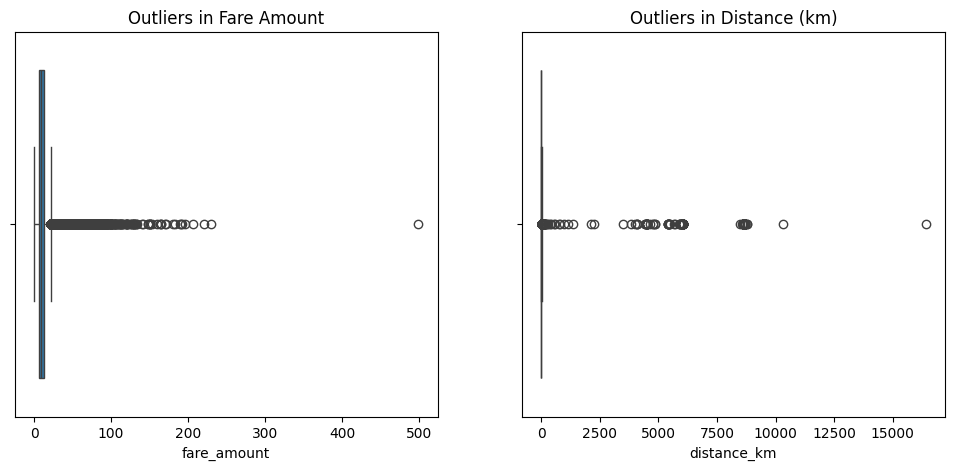

In [10]:
# ---- 3️⃣ Identify Outliers ----
# Visualize outliers in fare and distance
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(x=df['fare_amount'])
plt.title("Outliers in Fare Amount")

plt.subplot(1,2,2)
sns.boxplot(x=df['distance_km'])
plt.title("Outliers in Distance (km)")
plt.show()

In [12]:
# Remove extreme outliers
df = df[df['fare_amount'] < 100]  # Remove overly expensive rides
df = df[df['distance_km'] < 100]  # Remove unrealistically long trips


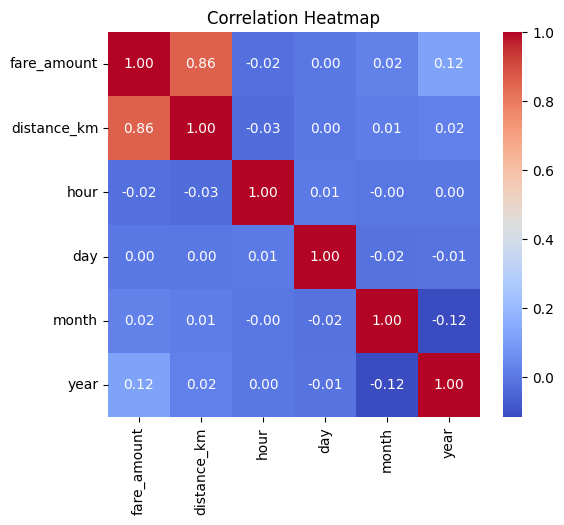

In [14]:
# ---- 4️⃣ Check Correlation ----
corr = df[['fare_amount', 'distance_km', 'hour', 'day', 'month', 'year']].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [16]:
# ---- 5️⃣ Prepare Data for Modeling ----
X = df[['distance_km', 'hour', 'day', 'month', 'year']]
y = df['fare_amount']

# Split data into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
# ---- 6️⃣ Train Models ----
lr = LinearRegression()
ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=0.1)

lr.fit(X_train_scaled, y_train)
ridge.fit(X_train_scaled, y_train)
lasso.fit(X_train_scaled, y_train)

Lasso(alpha=0.1)

In [20]:
# ---- 7️⃣ Predictions ----
y_pred_lr = lr.predict(X_test_scaled)
y_pred_ridge = ridge.predict(X_test_scaled)
y_pred_lasso = lasso.predict(X_test_scaled)


In [22]:
# ---- 8️⃣ Evaluation ----
def evaluate_model(y_test, y_pred, name):
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{name} Results:")
    print(f" R² Score: {r2:.4f}")
    print(f" RMSE: {rmse:.4f}")
    print(f" MAE: {mae:.4f}\n")
    return r2, rmse, mae

r2_lr, rmse_lr, mae_lr = evaluate_model(y_test, y_pred_lr, "Linear Regression")
r2_ridge, rmse_ridge, mae_ridge = evaluate_model(y_test, y_pred_ridge, "Ridge Regression")
r2_lasso, rmse_lasso, mae_lasso = evaluate_model(y_test, y_pred_lasso, "Lasso Regression")

Linear Regression Results:
 R² Score: 0.7230
 RMSE: 4.9481
 MAE: 2.3010

Ridge Regression Results:
 R² Score: 0.7230
 RMSE: 4.9481
 MAE: 2.3010

Lasso Regression Results:
 R² Score: 0.7233
 RMSE: 4.9460
 MAE: 2.3060



,Model,R2,RMSE,MAE
0,Linear,0.723023,4.948104,2.300991
1,Ridge,0.723023,4.948101,2.300996
2,Lasso,0.723261,4.945980,2.306031


/var/folders/nt/cm9_z_nx5yq0pgqw46gnrd_40000gn/T/ipykernel_15136/3982851638.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results, x='Model', y='R2', palette='Set2')


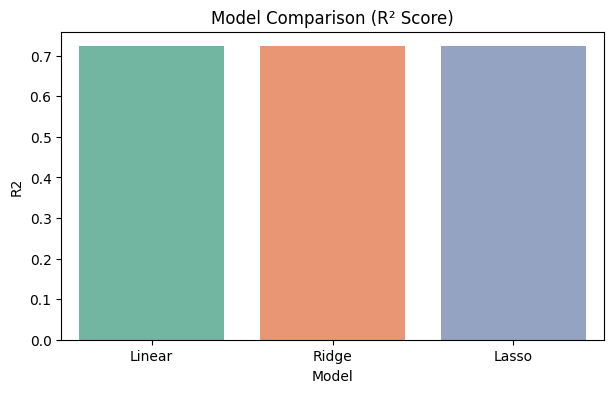

In [24]:
# ---- 9️⃣ Compare Models ----
results = pd.DataFrame({
    'Model': ['Linear', 'Ridge', 'Lasso'],
    'R2': [r2_lr, r2_ridge, r2_lasso],
    'RMSE': [rmse_lr, rmse_ridge, rmse_lasso],
    'MAE': [mae_lr, mae_ridge, mae_lasso]
})

display(results)

plt.figure(figsize=(7,4))
sns.barplot(data=results, x='Model', y='R2', palette='Set2')
plt.title("Model Comparison (R² Score)")
plt.show()

In [26]:
# ---- 🔟 Predict a Sample Ride ----
sample = pd.DataFrame({
    'distance_km': [10],
    'hour': [14],
    'day': [5],
    'month': [7],
    'year': [2016]
})

sample_scaled = scaler.transform(sample)
predicted_fare = ridge.predict(sample_scaled)[0]
print(f"Predicted Uber Fare for sample ride: ${predicted_fare:.2f}")

Predicted Uber Fare for sample ride: $28.12
